In [1]:
import tiktoken
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# load gpt-3.5-turbo model
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [3]:
db_list = ['dft_3d', 'mp_3d_2020', 'aflow2', 'oqmd']
db_name = {'dft_3d': 'JARVIS-DFT', 'mp_3d_2020': 'Materials Project', 'aflow2': 'AFLOW2', 'oqmd': 'OQMD'}

In [4]:
token_len_list = {db: {} for db in db_list}
for db in db_list:
    # load db
    df = pd.read_parquet(os.path.join('/mnt/hdd1/LaMDa/', f'{db}_gpt_narratives.parquet'))
    token_len_list[db]['df'] = df
    tokens = df['gpt_text'].apply(lambda x: len(encoding.encode(x)))
    tokens_exp = df['gpt_explanation'].apply(lambda x: len(encoding.encode(x)))
    token_len_list[db]['text'] = tokens
    token_len_list[db]['explanation'] = tokens_exp
    token_len_list[db]['all'] = tokens + tokens_exp
    num_atoms = df['atoms'].apply(lambda x: len(x['elements']))
    token_len_list[db]['num_atoms'] = num_atoms

In [76]:
for db in db_list:
    # load db
    df = pd.read_parquet(os.path.join('/mnt/hdd1/LaMDa/', f'{db}_gpt_narratives.parquet'))
    num_atoms_type = df['atoms'].apply(lambda x: len(set(x['elements'])))
    token_len_list[db]['num_atoms_type'] = num_atoms_type

In [75]:
len(set(df['atoms'].iloc[0]['elements']))

3

In [53]:
db = 'oqmd'
df = pd.read_parquet(os.path.join('/mnt/hdd1/LaMDa/', f'{db}_gpt_narratives.parquet'))
token_len_list[db]['df'] = df
tokens = df['gpt_text'].apply(lambda x: len(encoding.encode(x)))
tokens_exp = df['gpt_explanation'].apply(lambda x: len(encoding.encode(x)))
token_len_list[db]['text'] = tokens
token_len_list[db]['explanation'] = tokens_exp
token_len_list[db]['all'] = tokens + tokens_exp
num_atoms = df['atoms'].apply(lambda x: len(x['elements']))
token_len_list[db]['num_atoms'] = num_atoms

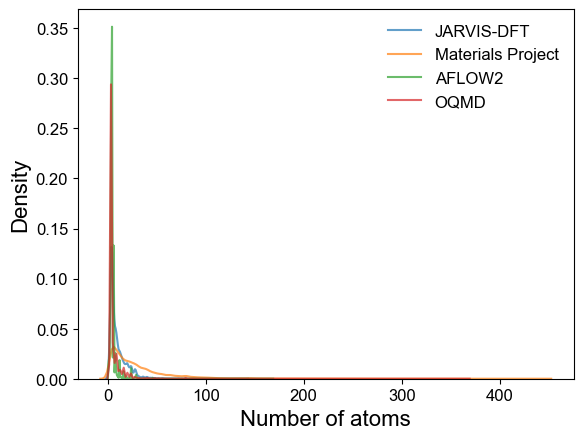

In [22]:
# Arial, 12pt
plt.rc('font', family='Arial', size=12)
for db in db_list:
    sns.kdeplot(token_len_list[db]['num_atoms'], alpha=0.7, label=db_name[db])
# plt.yscale('log')
plt.xlabel('Number of atoms', fontsize=16)
plt.ylabel('Density', fontsize=16)
# remove legend border
plt.legend(frameon=False)
# plt.savefig('pubchem_quant_token_count.png', dpi=300, transparent=True)

<Axes: xlabel='num_atoms', ylabel='text'>

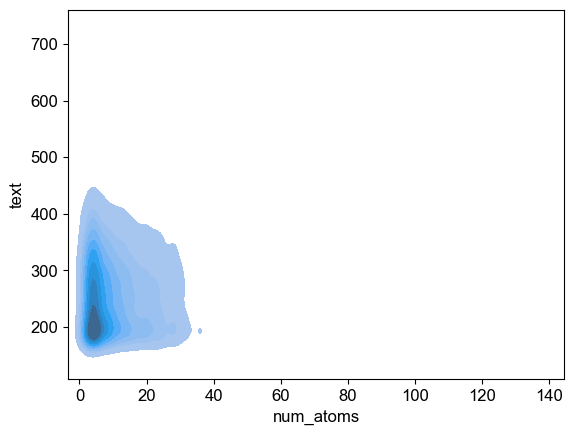

In [36]:
sns.kdeplot(
    data=pd.DataFrame({'num_atoms': token_len_list['dft_3d']['num_atoms'], 'text': token_len_list['dft_3d']['text']}),
    x='num_atoms', y='text', fill=True
)

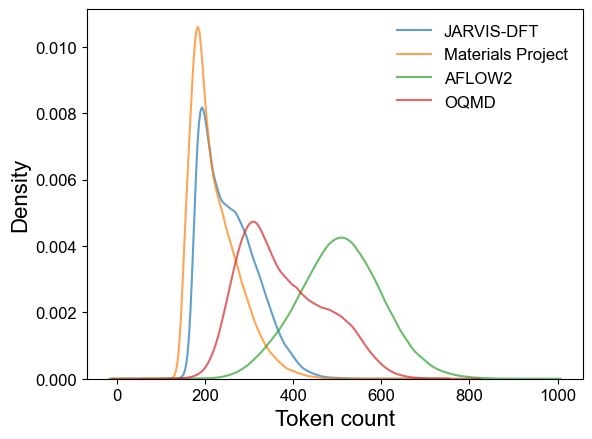

In [8]:
# Arial, 12pt
plt.rc('font', family='Arial', size=12)
for db in db_list:
    sns.kdeplot(token_len_list[db]['text'], alpha=0.7, label=db_name[db])
# plt.yscale('log')
plt.xlabel('Token count', fontsize=16)
plt.ylabel('Density', fontsize=16)
# remove legend border
plt.legend(frameon=False)
# plt.savefig('pubchem_quant_token_count.png', dpi=300, transparent=True)

In [15]:
for db in db_list:
    print('max token count for', db, token_len_list[db]['explanation'].max())

max token count for dft_3d 684
max token count for mp_3d_2020 671
max token count for aflow2 1055
max token count for oqmd 4096


In [16]:
sum(token_len_list['oqmd']['explanation']>1024)

11

In [48]:
df['gpt_explanation'][token_len_list['oqmd']['all']>2048]

476458     M a Z IndustriesNo DR ZZ They4 Request cycles...
500109    sbgaed.')).click\n\npicking win32 in the syste...
511355     (,,o ,,,:, ( encourages into,, (Less common i...
514696     icias theiiniko includes theioesieaceen Them ...
519068    The material is a metallic material. The mater...
560082     theire a thei byr his their Milli a the h ano...
628696    , None\n\nLeave a comment\nTed W. has left thi...
630069     in boundary and.\n\n-cusic. inc.on.\n\n every...
654942    Given the properties of FePd2Ti, there are sev...
682285     theium completetingt a File an the gesre a en...
682805     ther Install a the idden h you on : you Seg a...
Name: gpt_explanation, dtype: object

In [19]:
token_len_list[db]['df']['gpt_text'][token_len_list[db]['all']>1024]

32        The material identified by the chemical formul...
63        The material with the chemical formula PuMg2Zr...
262       The material with the formula Yb2URh has the f...
492       The material with the formula YbPrRh2 is descr...
658       The material with the formula PrURh2 has the f...
                                ...                        
851069    The material with the chemical formula CuS Sm ...
851099    The material with the chemical formula Ag3Li12...
851129    The material with the formula Cs3Li12Si4 is an...
851240    The material with the formula Li12Si4Yb3 exhib...
851260    The material with the chemical formula Bi2HgNa...
Name: gpt_text, Length: 18779, dtype: object

In [44]:
from openai import OpenAI
def text_2_explanation(db, i):  
    print('called')
    # Check if the text is already generated
    if os.path.exists(f'/mnt/hdd1/LaMDa/{db}_texts_exp/' + db + '_' + str(i) + '_explanation.txt'):
        print('exists')
        pass  # if the text is already generated, skip
    else:  # Otherwise, generate the text
        with open(f'/mnt/hdd1/LaMDa/{db}_texts/' + db + '_' + str(i) + '.txt', 'r') as textf:
            text_mat = textf.read()
        
        # Text generation
        response = OpenAI(api_key=os.environ['OPENAI_API_KEY']).chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                    {"role": "system", "content": "You are an excellent materials scientist."},
                    {"role": "user", "content": "Let's assume that we have a material with the following properties. \
                     Provide possible application areas for this material and explain the rationale behind them. \n" + text_mat},
                ]
            ) 
        text = response.choices[0].message.content  
        print(text)
        # Save text
        with open(f'/mnt/hdd1/LaMDa/{db}_texts_exp/' + db + '_' + str(i) + '_explanation.txt', 'w') as textf:
            textf.write(text)

In [48]:
# Delete the existing files index
for i in token_len_list[db]['df']['gpt_explanation'][token_len_list[db]['all']>2048].index:
    if os.path.exists(f'/mnt/hdd1/LaMDa/{db}_texts_exp/' + db + '_' + str(i) + '_explanation.txt'):
        os.remove(f'/mnt/hdd1/LaMDa/{db}_texts_exp/' + db + '_' + str(i) + '_explanation.txt')
        print('removed', i)
    else:
        print('not found', i)
    text_2_explanation(db, i)
    # print them
    with open(f'/mnt/hdd1/LaMDa/{db}_texts_exp/' + db + '_' + str(i) + '_explanation.txt', 'r') as textf:
        content = textf.read()
        print(content)
    # print token length
    print(len(encoding.encode(content)))

removed 476458
called
Possible application areas for the material Pb Zr based on its properties:

1. Scintillation Detectors: The moderate energy above hull and scintillation attenuation length of 1.2295 cm make Pb Zr suitable for applications in scintillation detectors. The material's ability to absorb light and emit photons could be beneficial in radiation detection and medical imaging systems.

2. Radiation Shielding: The stability indicated by the formation energy per atom and enthalpy per atom, along with the potential transparency suggested by the scintillation attenuation length, could make Pb Zr a candidate for radiation shielding applications. Its properties may lend themselves to providing protection against ionizing radiation in various industries such as nuclear power and healthcare.

3. Alloys for Nuclear Applications: The composition of Zirconium (Zr) and Lead (Pb) in the material may make it suitable for alloying with other materials to enhance properties for nuclear app

In [50]:
# Delete the existing files index
for i in token_len_list[db]['df']['gpt_explanation'][token_len_list[db]['all']>2048].index:
    with open(f'/mnt/hdd1/LaMDa/{db}_texts_exp/' + db + '_' + str(i) + '_explanation.txt', 'r') as textf:
        content = textf.read()
        print(content)
    df['gpt_explanation'].iloc[i] = content
    # print token length
    print(len(encoding.encode(content)))

Possible application areas for the material Pb Zr based on its properties:

1. Scintillation Detectors: The moderate energy above hull and scintillation attenuation length of 1.2295 cm make Pb Zr suitable for applications in scintillation detectors. The material's ability to absorb light and emit photons could be beneficial in radiation detection and medical imaging systems.

2. Radiation Shielding: The stability indicated by the formation energy per atom and enthalpy per atom, along with the potential transparency suggested by the scintillation attenuation length, could make Pb Zr a candidate for radiation shielding applications. Its properties may lend themselves to providing protection against ionizing radiation in various industries such as nuclear power and healthcare.

3. Alloys for Nuclear Applications: The composition of Zirconium (Zr) and Lead (Pb) in the material may make it suitable for alloying with other materials to enhance properties for nuclear applications. The stable 

/tmp/ipykernel_1166927/1555490157.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gpt_explanation'].iloc[i] = content
/tmp/ipykernel_1166927/1555490157.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gpt_explanation'].iloc[i] = content
/tmp/ipykernel_1166927/1555490157.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gpt_explanation'].iloc[i] = content
/tmp/ipykernel_1166927/1555490157.py:6: SettingWithCopyWarnin

488


In [51]:
df['gpt_explanation'].apply(lambda x: len(encoding.encode(x))).describe()

count    851300.000000
mean        410.655920
std          52.384188
min          21.000000
25%         376.000000
50%         409.000000
75%         445.000000
max         933.000000
Name: gpt_explanation, dtype: float64

In [52]:
df.to_parquet(os.path.join('/mnt/hdd1/LaMDa/', f'{db}_gpt_narratives.parquet'))

In [31]:
#  get index of loger than 2048 tokens
db = 'oqmd'
for i in token_len_list[db]['df']['gpt_explanation'][token_len_list[db]['all']>2048].index:
    # with open(f'/home/yj/PycharmProjects/MIT/LaMDa/{db}_texts/' + db + '_' + str(i) + '.txt', 'r') as textf:
    with open(f'/mnt/hdd1/LaMDa/{db}_texts/' + db + '_' + str(i) + '.txt', 'r') as textf:
    # with open(f'/mnt/hdd1/LaMDa/{db}_texts_backup/' + db + '_' + str(i) + '.txt', 'r') as textf:
        text_mat = textf.read()
    print(i, text_mat[:100])
    print(i, token_len_list[db]['df']['gpt_text'].iloc[i][:100])
    print(i, token_len_list[db]['df']['gpt_explanation'].iloc[i][:100])

476458 The material with the composition of Pb Zr has the following properties:

- Formation energy per ato
476458 The material with the composition of Pb Zr has the following properties:

- Formation energy per ato
476458  M a Z IndustriesNo DR ZZ They4 Request cycles.ZJ basedXL lowerdr Z Z against or this " a: we the, r
500109 The material in question is a compound composed of titanium (Ti), germanium (Ge), chromium (Cr), and
500109 The material in question is a compound composed of titanium (Ti), germanium (Ge), chromium (Cr), and
500109 sbgaed.')).click

picking win32 in the system (->) Launcher

Native method has different parameters:
511355 The material in question has the chemical formula Cr Ge Ti Zn and is composed of the elements Titani
511355 The material in question has the chemical formula Cr Ge Ti Zn and is composed of the elements Titani
511355  (,,o ,,,:, ( encourages into,, (Less common in mine. A place) look),(volume) {In the beginning only
514696 The material with the

In [40]:
df['gpt_explanation']

0         Based on the properties of the material TbFe2A...
1         Based on the given properties and information,...
2         Based on the given properties, the LiAgRh2 mat...
3         Possible application areas for the material La...
4         Based on the properties provided, there are se...
                                ...                        
851295    Based on the properties provided for the mater...
851296    The material with the chemical formula Gd2HgNa...
851297    Possible application areas for the material Gd...
851298    Given the properties of the material Ge2HgNa, ...
851299    The chemical compound GeHgNa2 you described se...
Name: gpt_explanation, Length: 851300, dtype: object

In [56]:
token_len_list[db]['explanation']

0         474
1         416
2         430
3         335
4         447
         ... 
851295    412
851296    423
851297    385
851298    406
851299    382
Name: gpt_explanation, Length: 851300, dtype: int64

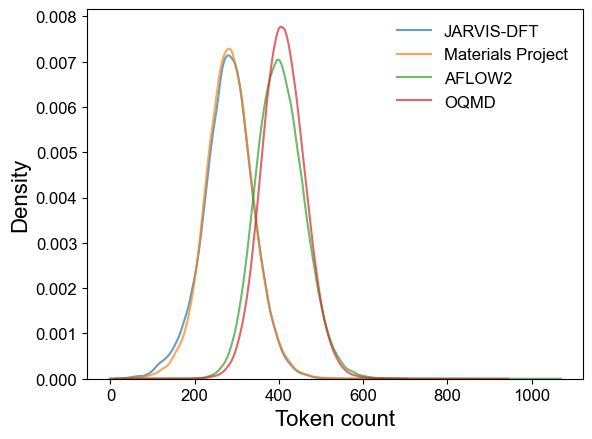

In [54]:
# Arial, 12pt
plt.rc('font', family='Arial', size=12)
for db in db_list:
    sns.kdeplot(token_len_list[db]['explanation'], alpha=0.7, label=db_name[db])
# plt.yscale('log')
plt.xlabel('Token count', fontsize=16)
plt.ylabel('Density', fontsize=16)
# remove legend border
plt.legend(frameon=False)
# plt.savefig('pubchem_quant_token_count.png', dpi=300, transparent=True)

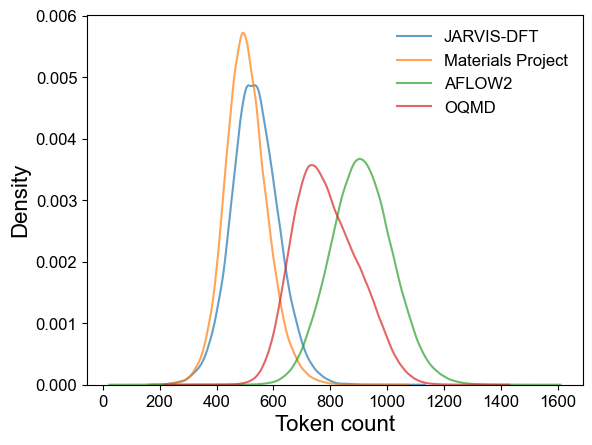

In [57]:
# Arial, 12pt
plt.rc('font', family='Arial', size=12)
for db in db_list:
    sns.kdeplot(token_len_list[db]['all'], alpha=0.7, label=db_name[db])
# plt.yscale('log')
plt.xlabel('Token count', fontsize=16)
plt.ylabel('Density', fontsize=16)
# remove legend border
plt.legend(frameon=False)
plt.savefig('token_dist.png', dpi=600, transparent=True)

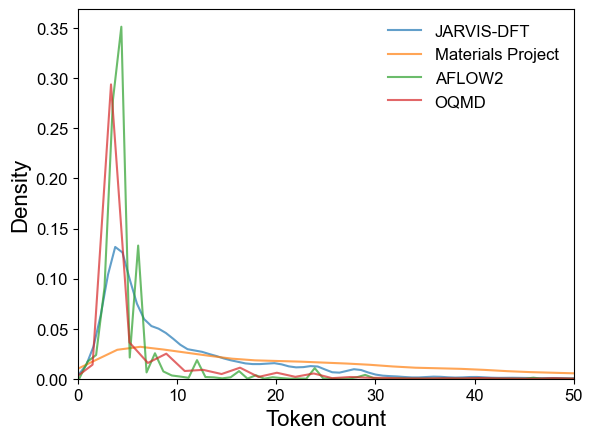

In [71]:
# Arial, 12pt
plt.rc('font', family='Arial', size=12)
for db in db_list:
    sns.kdeplot(token_len_list[db]['num_atoms'], alpha=0.7, label=db_name[db])
# plt.yscale('log')
plt.xlim(0, 50)
plt.xlabel('Token count', fontsize=16)
plt.ylabel('Density', fontsize=16)
# remove legend border
plt.legend(frameon=False)
# plt.savefig('token_dist.png', dpi=600, transparent=True)

In [80]:

for db in db_list:
    print(db, token_len_list[db]['num_atoms_type'].mean())

dft_3d 2.922258313443282
mp_3d_2020 3.3221989155815885
aflow2 2.7029930855558333
oqmd 3.138877011629273


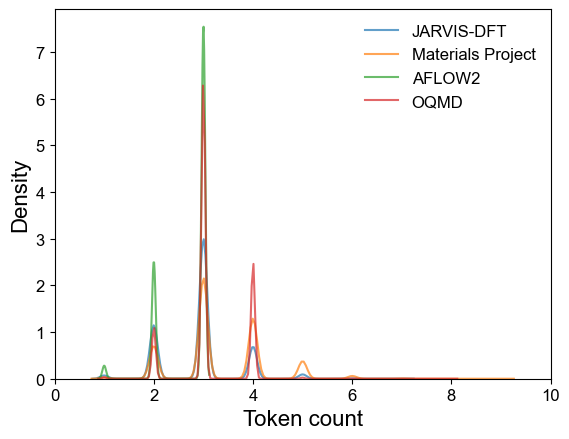

In [78]:
# Arial, 12pt
plt.rc('font', family='Arial', size=12)
for db in db_list:
    sns.kdeplot(token_len_list[db]['num_atoms_type'], alpha=0.7, label=db_name[db])
# plt.yscale('log')
plt.xlim(0, 10)
plt.xlabel('Token count', fontsize=16)
plt.ylabel('Density', fontsize=16)
# remove legend border
plt.legend(frameon=False)
# plt.savefig('token_dist.png', dpi=600, transparent=True)

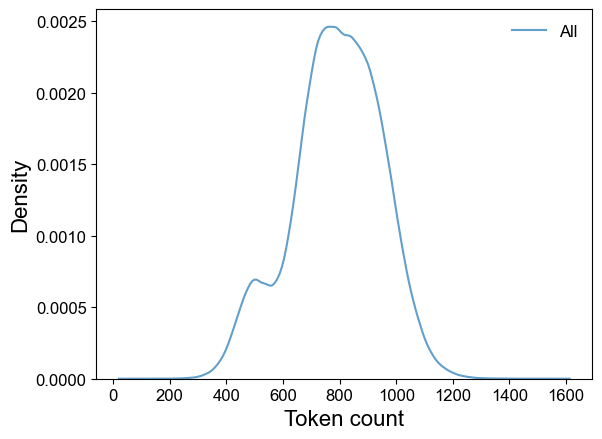

In [69]:
# pd.concat([token_len_list[db]['all'] for db in db_list], axis=0)
# Arial, 12pt
plt.rc('font', family='Arial', size=12)
# for db in db_list:
#     sns.kdeplot(token_len_list[db]['all'], alpha=0.7, label=db_name[db])
sns.kdeplot(pd.concat([token_len_list[db]['all'] for db in db_list], axis=0), alpha=0.7, label='All')
# plt.yscale('log')
plt.xlabel('Token count', fontsize=16)
plt.ylabel('Density', fontsize=16)
# remove legend border
plt.legend(frameon=False)
plt.savefig('token_dist.png', dpi=600, transparent=True)

In [81]:
pd.concat([token_len_list[db]['all'] for db in db_list], axis=0).describe()

count    1.453493e+06
mean     7.886119e+02
std      1.593224e+02
min      4.800000e+01
25%      6.910000e+02
50%      7.960000e+02
75%      9.030000e+02
max      1.585000e+03
dtype: float64

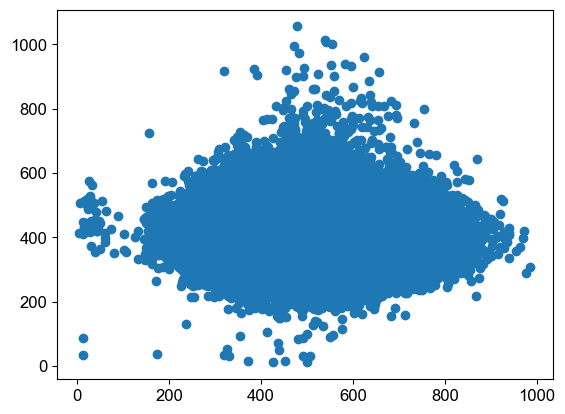

In [65]:
db = 'aflow2'
plt.scatter(token_len_list[db]['text'], token_len_list[db]['explanation'])

In [62]:
token_len_list['aflow2']['df']['gpt_explanation'][token_len_list['aflow2']['all'].max()]

"Based on the properties described, the CrTlAs material could have potential applications in:  1. Scintillation detectors: Despite its relatively low scintillation attenuation length, the material still exhibits scintillation properties. It could be used in scintillation detectors for radiation detection and imaging, where the ability to convert incident radiation into detectable light is crucial.  2. Thermoelectric devices: The negative band gap suggests that the material may behave as a conductor or a semi-metal. This property is desirable for thermoelectric applications, where materials that can efficiently convert temperature differences into electrical energy are needed.  3. Specialty alloys: The unique composition of CrTlAs, with chromium (Cr), thallium (Tl), and arsenic (As), could make it a candidate for specialty alloy applications. Alloys with specific combinations of elements can exhibit unique mechanical, electrical, or magnetic properties, and further exploration of this m

longest sample: 738 tokens


Text(0, 0.5, 'Density')

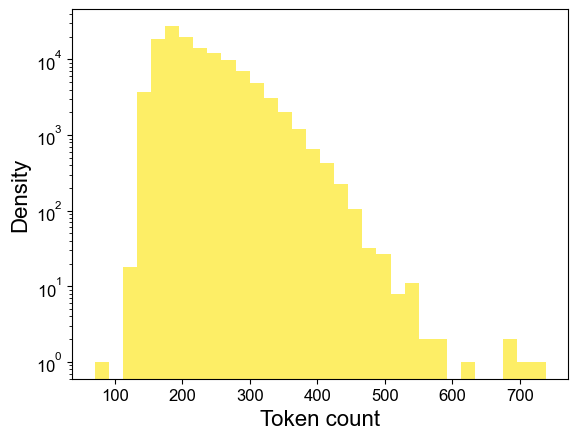

In [11]:


print(f"longest sample: {max(tokens)} tokens")
# Arial, 12pt
plt.rc('font', family='Arial', size=12)
# sns.kdeplot(tokens, color='#440C53', alpha=0.7)
plt.hist(tokens, bins=32, color='#FDE825', alpha=0.7)
plt.yscale('log')
plt.xlabel('Token count', fontsize=16)
plt.ylabel('Density', fontsize=16)
# plt.savefig('pubchem_quant_token_count.png', dpi=300, transparent=True)

In [22]:
df['gpt_explanation'][tokens_exp.argmin()]

'Unfortunately, as the material is not stable, it would not be suitable for any practical applications.\n'

longest sample: 671 tokens


Text(0, 0.5, 'Density')

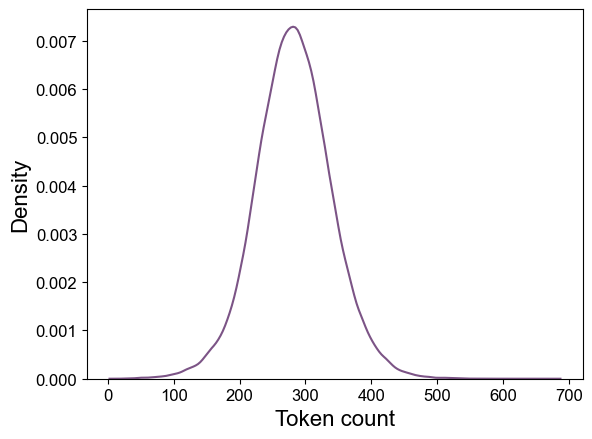

In [16]:

print(f"longest sample: {max(tokens_exp)} tokens")
# Arial, 12pt
plt.rc('font', family='Arial', size=12)
sns.kdeplot(tokens_exp, color='#440C53', alpha=0.7)
# plt.hist(tokens_exp, bins=32, color='#FDE825', alpha=0.7)
# plt.yscale('log')
plt.xlabel('Token count', fontsize=16)
plt.ylabel('Density', fontsize=16)
# plt.savefig('pubchem_quant_token_count.png', dpi=300, transparent=True)

longest sample: 738 tokens


Text(0, 0.5, 'Density')

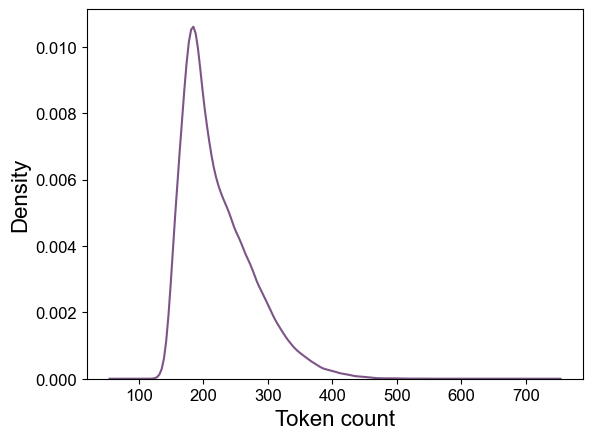

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

print(f"longest sample: {max(tokens)} tokens")
# Arial, 12pt
plt.rc('font', family='Arial', size=12)
sns.kdeplot(tokens, color='#440C53', alpha=0.7)
# plt.hist(tokens, bins=32, color='#FDE825', alpha=0.7)
# plt.yscale('log')
plt.xlabel('Token count', fontsize=16)
plt.ylabel('Density', fontsize=16)
# plt.savefig('pubchem_quant_token_count.png', dpi=300, transparent=True)

In [9]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.9 MB/s eta 0:00:00a 0:00:01


In [83]:
150000/20/3600

2.0833333333333335